# Linear regression
Very simple first-approach model for temperature, which uses single lamps and average sensor data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
import seaborn as sns
from mpl_toolkits import mplot3d
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
# Read dataset
df = pd.read_csv("../data/processed/data_single_lamps_avg_sensors_clean.csv", parse_dates=["time"])

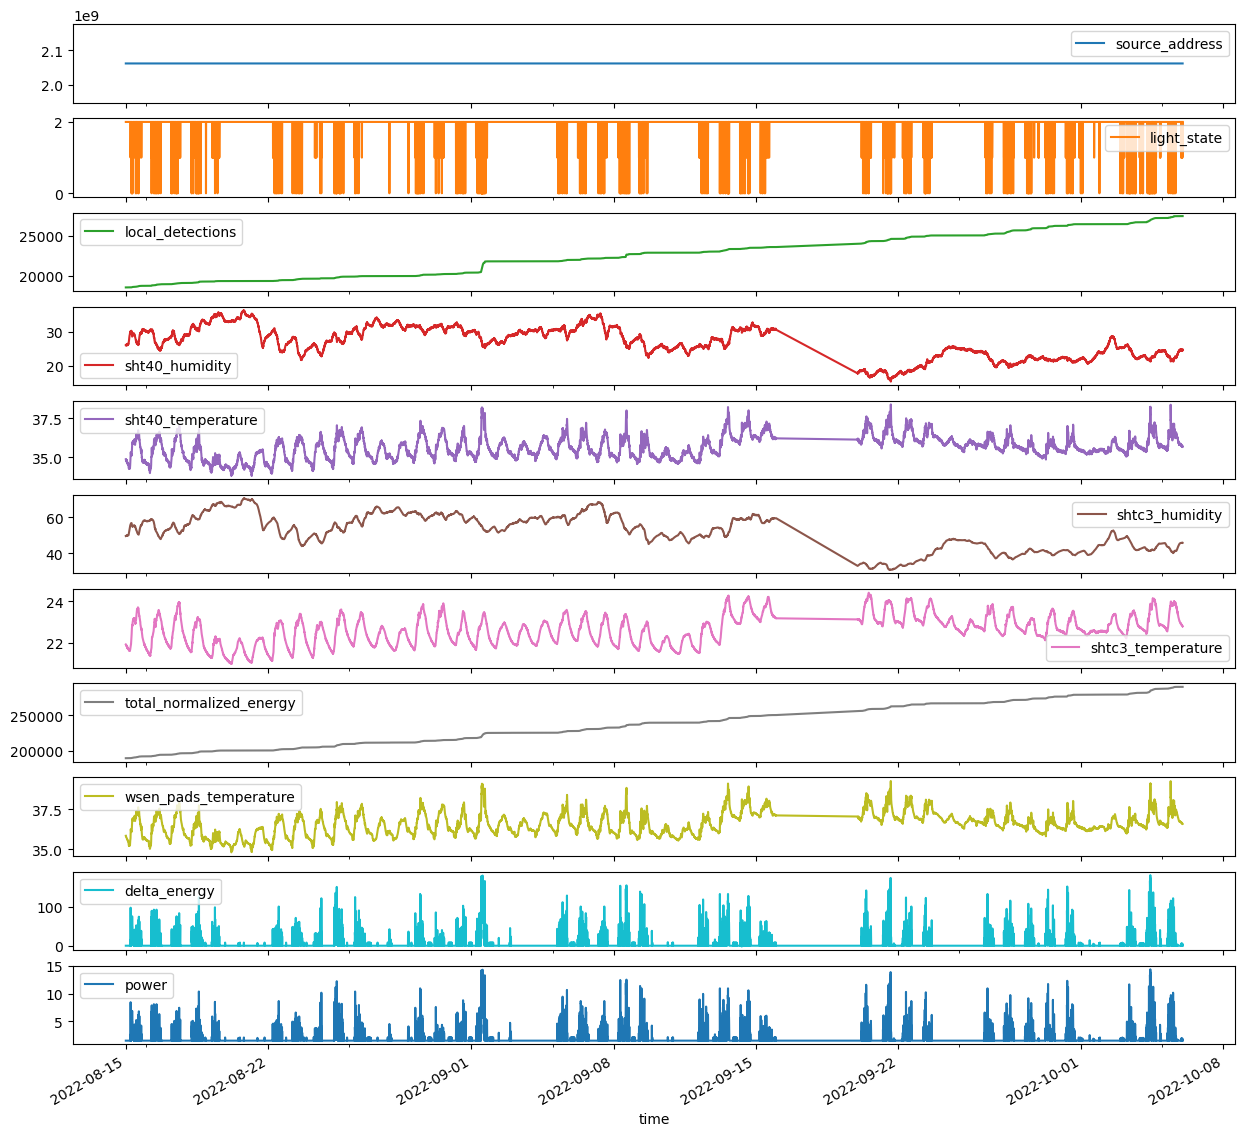

In [3]:
# Plot simple visualization of the dataset, for a single lamp
df[df['source_address'] == 2062404276].set_index('time').plot(subplots = True, figsize = (15,15));

In [4]:
lamps = df['source_address'].unique()

## Simple visualization 

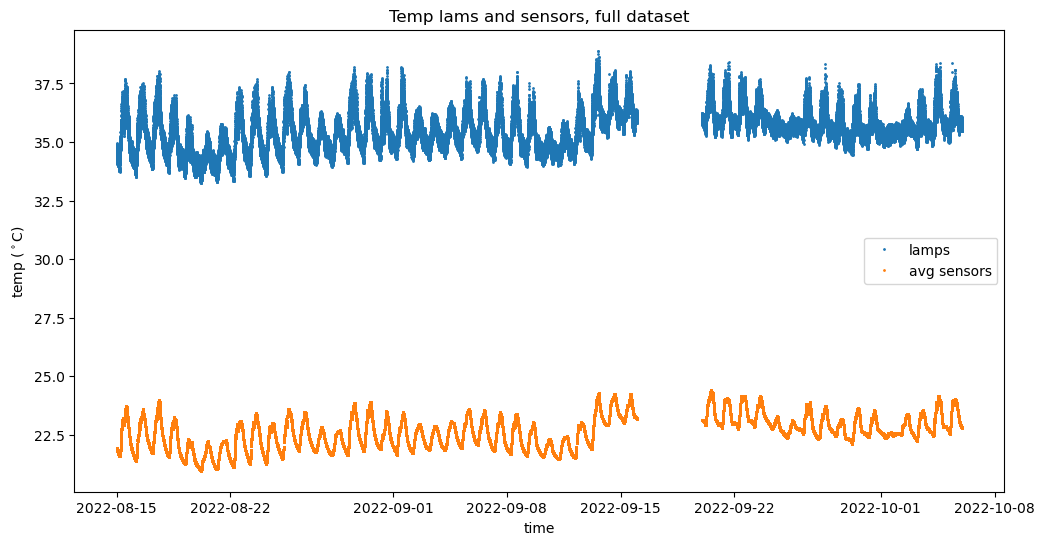

In [5]:
# Plot input data, which will be used for the model

fig, ax = plt.subplots(1,1, figsize = (12,6))

ax.plot(df['time'], df['sht40_temperature'],  marker = 'o', markersize = 1, linestyle = "", label = 'lamps')
ax.plot(df['time'], df['shtc3_temperature'],  marker = 'o', markersize = 1, linestyle = "", label = 'avg sensors')
ax.set_title('Temp lams and sensors, full dataset')

ax.set_xlabel('time')
ax.set_ylabel('temp ($^\circ$C)')
ax.legend()

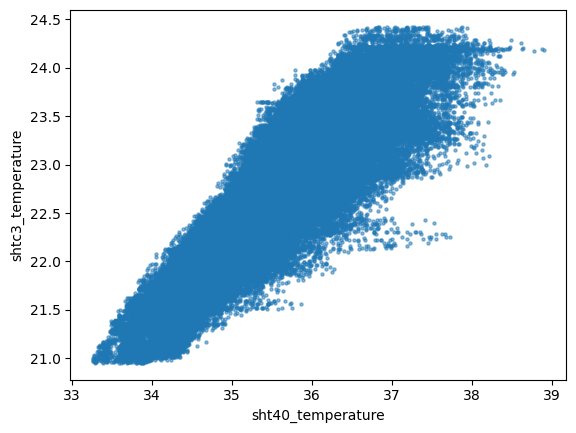

In [6]:
# Check the spread of the data: temperature real vs temperature lamp
size = 5
df.plot.scatter(x='sht40_temperature', y='shtc3_temperature', s=size, alpha=.5);

Remove single lamp/s to use it as unseen data later on to test the model.

In [7]:
lamp_chosen = lamps[0]

# unseen dataset to test the model 
df_unseen = df[df['source_address'] == lamp_chosen].copy()

In [8]:
# dataset used for modeling
df = df[~(df['source_address'].isin([lamp_chosen]))]

lamps_used = lamps[~np.isin(lamps, lamp_chosen)]

## Train - test split

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[['source_address','time','sht40_temperature', 'power']], 
                                                    df['shtc3_temperature'], 
                                                    test_size=0.3, 
                                                    random_state=17)

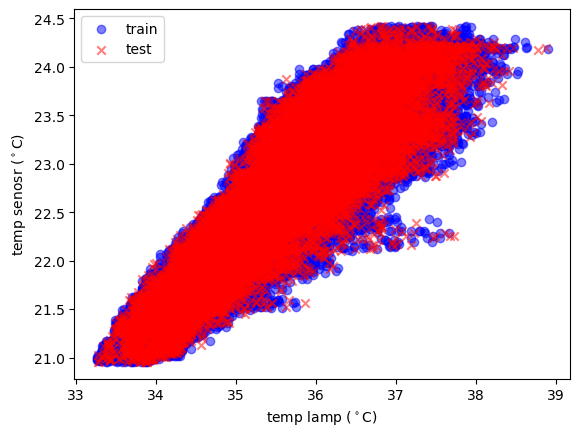

In [10]:
# Plot only temperature relationship of train and test
plt.scatter(X_train['sht40_temperature'], y_train, color = 'blue', marker='o', alpha=.5, label = 'train')
plt.scatter(X_test['sht40_temperature'], y_test, color = 'red', marker='x', alpha=.5, label = 'test');
plt.xlabel('temp lamp ($^\circ$C)')
plt.ylabel('temp senosr ($^\circ$C)')
plt.legend()

## Feature scaling

In [11]:
from sklearn.preprocessing import StandardScaler

# initialize object of StandardScaler class
ss = StandardScaler() 

X_train_scaled = ss.fit_transform(X_train.drop(columns = ['time', 'source_address'])) 

X_test_scaled = ss.transform(X_test.drop(columns = ['time', 'source_address'])) 

## Train the model

In [12]:
# Train the model
from sklearn.linear_model import LinearRegression

regr = LinearRegression()

regr.fit(X_train_scaled, y_train)

pred = regr.predict(X_test_scaled)

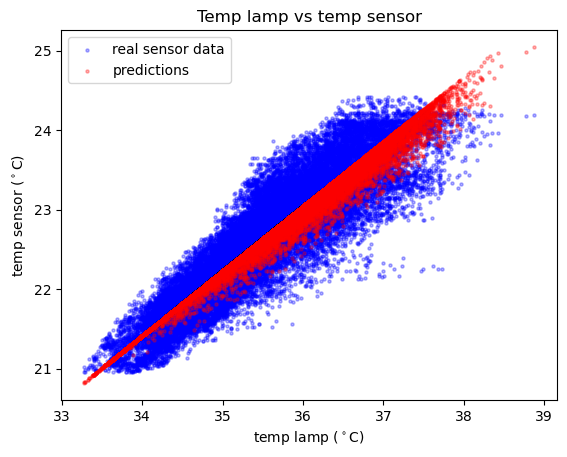

In [13]:
# Plot prediciotns together with the real data
size = 5
# 2D => temp - temp plot
plt.scatter(X_test['sht40_temperature'], y_test, color = 'blue', s=size, alpha=.3, label = 'real sensor data')
plt.scatter(X_test['sht40_temperature'], pred, color = 'red', s=size, alpha=.3, label = 'predictions')
plt.xlabel('temp lamp ($^\circ$C)')
plt.ylabel('temp sensor ($^\circ$C)')
plt.legend()
plt.title('Temp lamp vs temp sensor')
plt.show()

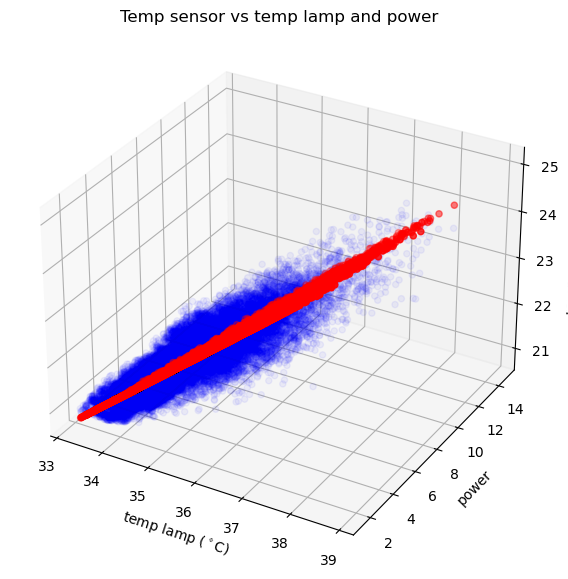

In [14]:
# 3D => pred temp vs temp and power
x = X_test['sht40_temperature']
y = X_test['power']
z1 = pred
z2 = y_test

fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection ='3d')
ax.scatter3D(x, y, z2, color = 'blue', alpha = 0.05)
ax.scatter3D(x, y, z1, color = 'red')
ax.set_title('Temp sensor vs temp lamp and power')
ax.set_xlabel('temp lamp ($^\circ$C)')
ax.set_ylabel('power')
ax.set_zlabel('temp sensor ($^\circ$C)')


plt.show()

(19240.375, 19245.541666666668)

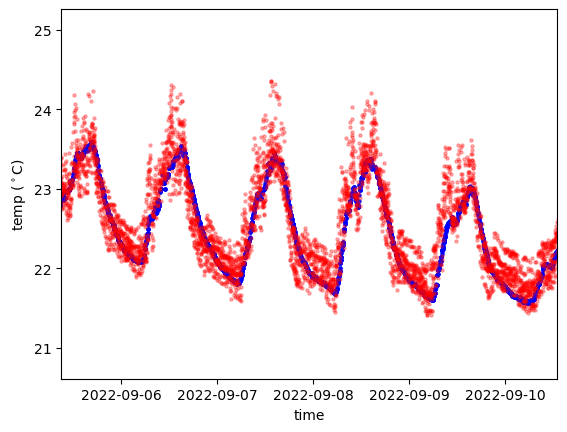

In [15]:
# Plot  real ambient(blue) and predictions for all the lamps together (red)  

fig, ax = plt.subplots()
ax.scatter( X_test['time'], y_test, color = 'blue', s=size, alpha=.8);
ax.scatter(X_test['time'], pred, color = 'red', s=size, alpha=.3);
ax.set_xlabel('time')
ax.set_ylabel('temp ($^\circ$C)')
ax.set_xlim(pd.to_datetime('2022-09-5 9:00:00'), pd.to_datetime('2022-09-10 13:00:00'))

In [16]:
lamps = df['source_address'].unique()

In [17]:
# Create dataset to visualize predicions
df_test = X_test.copy() 
df_test['pred'] = pred
# add sensor temperature to df for plotting
df_test = pd.concat([df_test, df['shtc3_temperature']], 1).dropna()
df_test = df_test.astype({"source_address": int})
df_test.set_index(['source_address', 'time'], inplace = True)

C:\Users\Anita\AppData\Local\Temp\ipykernel_11436\2009283893.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df_test = pd.concat([df_test, df['shtc3_temperature']], 1).dropna()


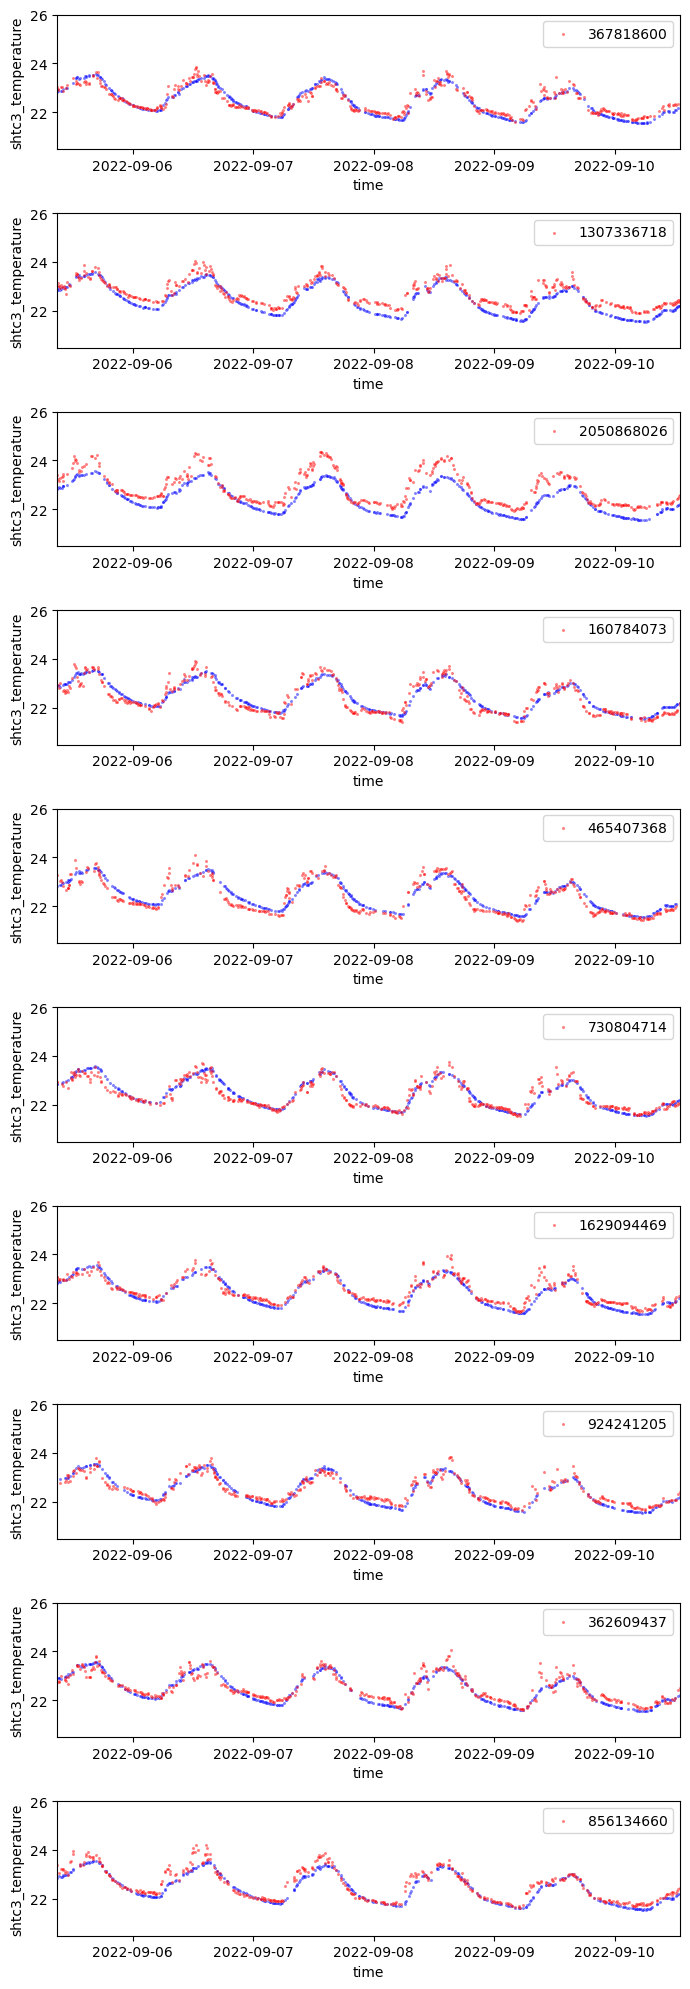

In [39]:
# Plot predictions for each lamp (red) and real output(blue)
size = 5
fig, axes = plt.subplots(len(lamps_used), 1)
fig.set_figheight(20)
fig.set_figwidth(7)
for i in range(len(lamps_used)):
    sns.scatterplot(ax = axes[i],data = df_test.loc[lamps[i]], x='time', y='shtc3_temperature', s=size, alpha=.5, color = 'blue');
    sns.scatterplot(ax = axes[i],data = df_test.loc[lamps[i]], x='time', y='pred', s=size, alpha=.5, color = 'red', label = lamps[i]); 
    axes[i].set_ylim(20.5, 26)
    axes[i].set_xlim(pd.to_datetime('2022-09-5 9:00:00'), pd.to_datetime('2022-09-10 13:00:00'))
    axes[i].legend()
    
plt.tight_layout()  
plt.show()


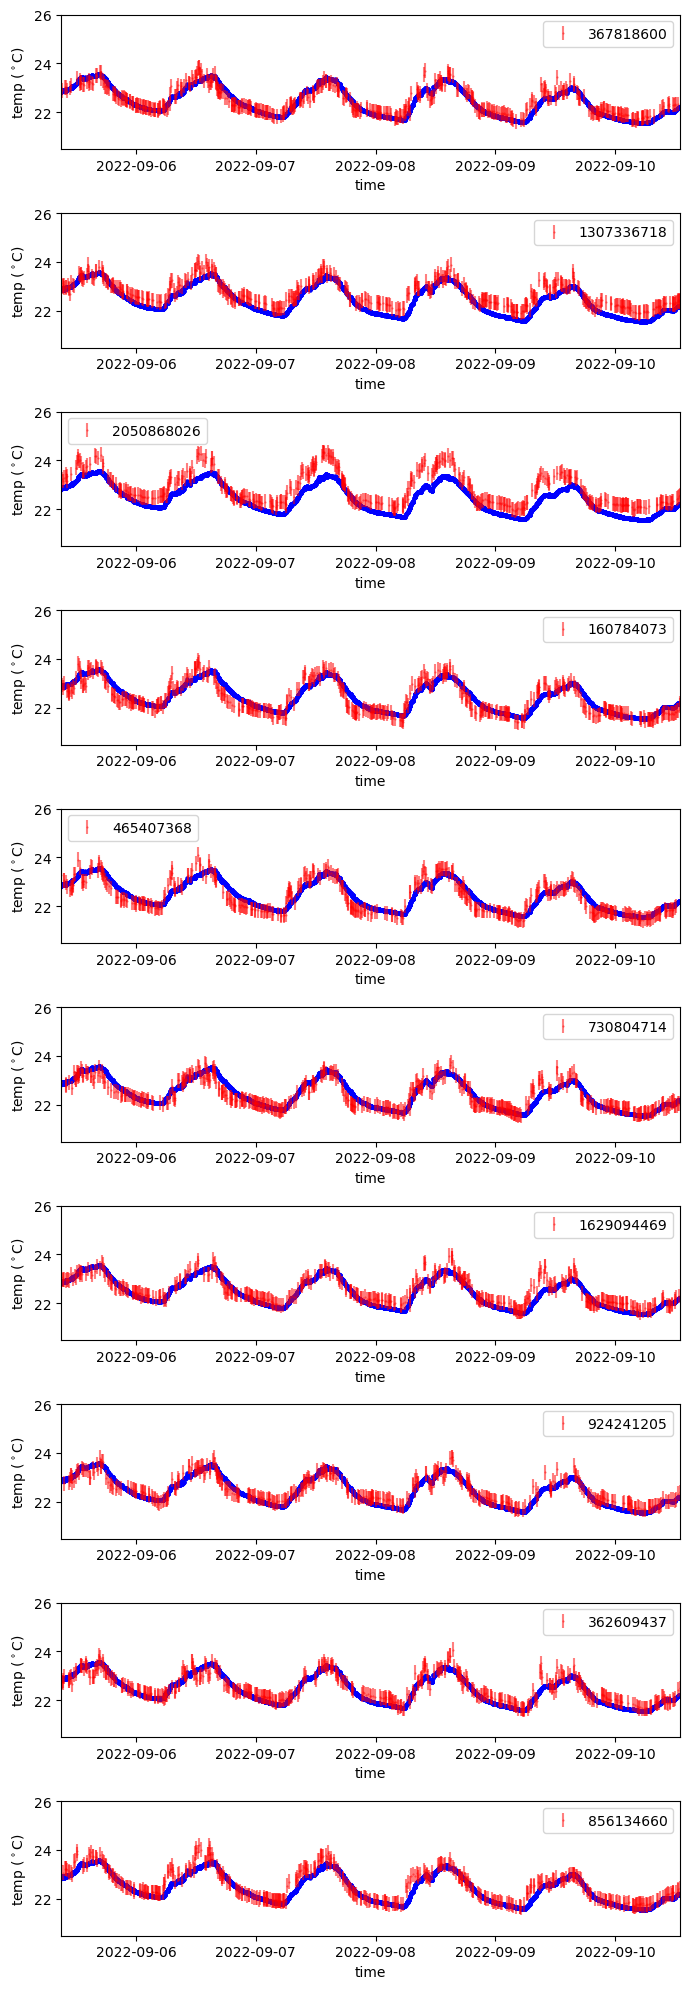

In [41]:
# Plot predictions for each lamp (red) and real output(blue) with errorbars

fig, axes = plt.subplots(len(lamps_used), 1)
fig.set_figheight(20)
fig.set_figwidth(7)
for i in range(len(lamps_used)):
    axes[i].errorbar(df_test.reset_index(level = 1).loc[lamps[i]]['time'], df_test.loc[lamps[i]]['pred'], yerr =np.sqrt(metrics.mean_squared_error(y_test, pred)), fmt='o', markersize = 0.5, color = 'red', label = lamps[i], alpha = 0.5) # plot vs x_position to see if there is any trend
    axes[i].scatter( X_test['time'], y_test, color = 'blue', s=size, alpha=1)
    axes[i].set_ylim(20.5, 26)
    axes[i].set_xlim(pd.to_datetime('2022-09-5 9:00:00'), pd.to_datetime('2022-09-10 13:00:00'))
    axes[i].set_xlabel('time')
    axes[i].set_ylabel('temp ($^\circ$C)')
    axes[i].legend()
    
plt.tight_layout()  
plt.show()


In [20]:
# Get metrics of the model


print('MAE', metrics.mean_absolute_error(y_test, pred))
print('MSE', metrics.mean_squared_error(y_test, pred))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_test, pred)))
print('R2 Score', metrics.r2_score(y_test, pred))


MAE 0.23249794852527397
MSE 0.08985410843834861
RMSE 0.2997567487786532
R2 Score 0.8142005858311617


In [21]:
# Cross validation scores
from sklearn.model_selection import cross_val_score

scores = cross_val_score(regr, X_train.drop(columns = ['time']), y_train, cv=5, scoring='r2')
scores

array([0.84043614, 0.84389725, 0.83791715, 0.8408734 , 0.84023587])

In [22]:
# Coefficients in linear regression
print("Coefficients: \n", regr.coef_)
# Intercept of linear regression
print("Intercept: \n", regr.intercept_)

Coefficients: 
 [ 0.65465536 -0.07156721]
Intercept: 
 22.620400172947203


In [23]:
# Put coefficients into a data frame
pd.DataFrame({
    'Feature': X_train.drop(columns = ['time', 'source_address']).columns,
    'Coef':  regr.coef_
}).sort_values(by=['Coef'], ascending=False)

Feature      Coef
0  sht40_temperature  0.654655
1              power -0.071567

## Check the model on unseen data

In [24]:
df_unseen = df_unseen[['source_address','time','sht40_temperature', 'power', 'shtc3_temperature']]

# Scale the unseen data
unseen_scaled = ss.transform(df_unseen.drop(columns = ['time', 'source_address', 'shtc3_temperature'])) 

# Predict on the unseen data
pred_unseen = regr.predict(unseen_scaled)

# Real output value
y_unseen = df_unseen['shtc3_temperature']

In [35]:
pred_unseen

array([22.12153866, 22.10526869, 22.08086374, ..., 22.82165079,
       22.82114741, 22.79674245])

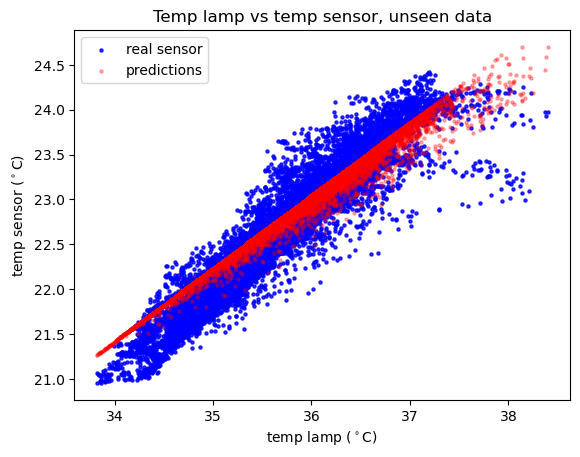

In [25]:
# 2D Plot predictions (red) and real output(blue) of the unseen data

plt.scatter(df_unseen['sht40_temperature'], y_unseen, color = 'blue', s=size, alpha=.8, label = 'real sensor');
plt.scatter(df_unseen['sht40_temperature'], pred_unseen, color = 'red', s=size, alpha=.3, label = 'predictions')
plt.xlabel('temp lamp ($^\circ$C)')
plt.ylabel('temp sensor ($^\circ$C)')
plt.legend()
plt.title('Temp lamp vs temp sensor, unseen data')
plt.show()

In [26]:
# Get metrics on unseen data 

print('MAE', metrics.mean_absolute_error(y_unseen, pred_unseen))
print('MSE', metrics.mean_squared_error(y_unseen, pred_unseen))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_unseen, pred_unseen)))
print('R2 Score', metrics.r2_score(y_unseen, pred_unseen))

MAE 0.212373850753725
MSE 0.07225685391128324
RMSE 0.2688063502063953
R2 Score 0.850632344044604


## Visualisation of performance on unseen data

In [36]:
# df_unseen.reset_index(inplace = True)
df_unseen['time'] = df_unseen['time'].apply(pd.to_datetime, format = '%y-%m-%d %H:%M:%s')
df_unseen['pred'] = pred_unseen.tolist()
# df_plot = df[df['source_address'] == lamp_chosen].sort_values(by="time", key=pd.to_datetime)

In [ ]:
df.head()

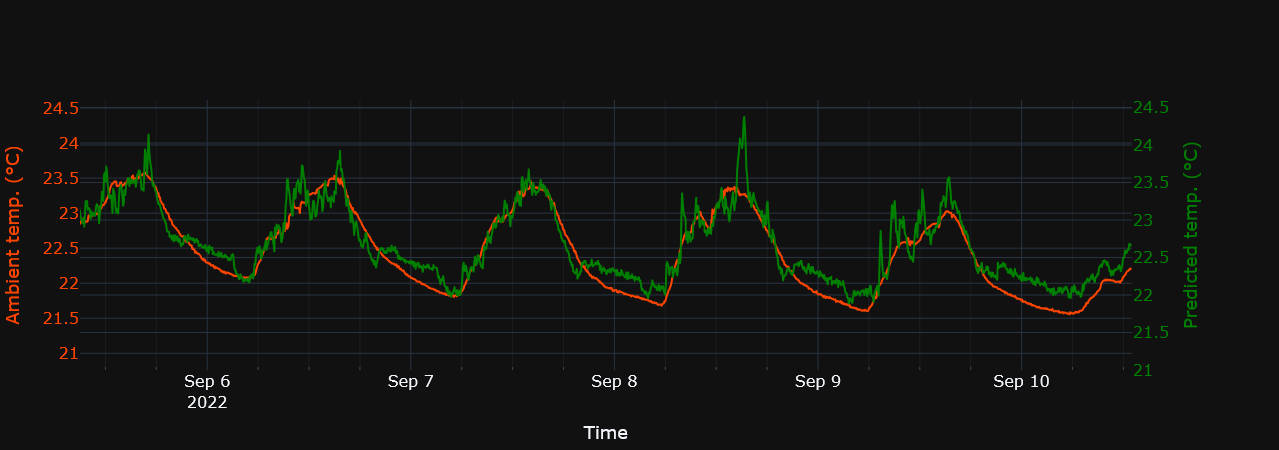

In [42]:
subfig = make_subplots(specs=[[{"secondary_y": True}]])


fig = px.line(df_unseen, x='time', y=['shtc3_temperature'], 
               width=900, height=450, render_mode="webgl" 
            )
fig2 = px.line(df_unseen, x='time', y=['pred'], 
               width=900, height=450 
            )

fig.update_traces(marker=dict(color='orangered'))
fig2.update_traces(marker=dict(color='green'))




fig2.update_traces(yaxis="y2")

subfig.add_traces(fig.data + fig2.data)
subfig.layout.xaxis.title="Time"
subfig.layout.yaxis.title="Ambient temp. (°C)"
# subfig.update_layout(yaxis=dict(range=[35.2,35.5]))


# subfig.layout.yaxis2.type="log"
subfig.layout.yaxis2.title="Predicted temp. (°C)"
subfig.update_layout(yaxis2=dict(range=[21,24.6]))
subfig.update_layout(showlegend=False)
# recoloring is necessary otherwise lines from fig und fig2 would share each color

subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
# subfig.for_each_trace(lambda t: t.update(yaxes_color=dict(color=t.marker.color)))
subfig.update_layout(template="plotly_dark")
subfig.update_xaxes(minor=dict(ticks="inside", showgrid=True))
subfig.update_xaxes(range = [pd.to_datetime('2022-09-5 9:00:00'), pd.to_datetime('2022-09-10 13:00:00')])
subfig.update_yaxes(title_font=dict(size=18))
subfig.update_yaxes(tickfont_size=16)

subfig.update_xaxes(title_font=dict(size=18))
subfig.update_xaxes(tickfont_size=16)
subfig.update_layout(height=450)
subfig.update_layout(width=900)

subfig.update_layout(yaxis2_color = 'green')
subfig.update_layout(yaxis_color = 'orangered')

# subfig.write_image("blog_red.png")
subfig.show()